<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

### Machine Learning
# 5. Programming Neural Networks with Theano

### [Luis Martí](http://lmarti.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
$\newcommand{\vec}[1]{\boldsymbol{#1}}$

In [1]:
import os, sys, gzip
import six.moves.cPickle as pickle

import numpy

import theano
import theano.tensor as T
import theano.d3viz as d3viz

from IPython.display import Image, SVG, IFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

In [2]:
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# What about `theano`?

* Mathematical symbolic expression compiler
  * Easy to define expressions
  * Expressions are similar numpy's syntax and semantics
* Possible to manipulate those expressions
  * Substitutions
  * **Gradient**, R operator
* Stability optimizations
Fast to compute values for those expressions
* Speed optimizations
* Use fast back-ends (GPUs (CUDA), BLAS, custom C code)
* Tools to inspect and check for correctness

Theano defines a *language*, a *compiler*, and a *library*.
  * Define a symbolic expression
  * Compile a function that can compute values
  * Execute that function on numeric values

The graph that represents mathematical operations is bipartite, and has two sorts of nodes:
* **Variable nodes**, that represent data
* **Apply nodes**, that represent the application of mathematical operations 

In practice:
* Variables values are used for the graph inputs and outputs, and intermediate values
* Variables will hold data during the function execution phase
* An Apply node has inputs and outputs, which are Variables
* An Apply node represents the specific application of an Op on these input variables
* The same Variable can be used as inputs by several Apply nodes

## Shared variables
* Symbolic variables, with a value associated to them
*  The value is persistent across function calls
*   The value is shared among all functions
*   The variable has to be an input variable
*   The variable is an implicit input to all functions using it

An optimization replaces a part of the graph with different nodes.
* The types of the replaced nodes have to match
* Merge equivalent computations
* Simplify expressions: $\frac{x}{x}$ becomes $1$
* Numerical stability: For example, gives the right answer for  $\log(1 + x)$  even if $x$ is really small.
* Insert in-place an destructive versions of operations
* Use specialized, high-performance versions (Elemwise loop fusion, GEMV,
GEMM)
* Shape inference
* Constant folding
* Transfer to GPU

## Using GPUs

Theano tries to make the use of GPUs as transparent as possible,
* Currently limited to `float32` `dtype`
* Not easy to interact in Python with `CudaNdarrays`

Select GPU by setting the device  flag to ’gpu’ or 'gpu{0,1,2,...}'.
* All `float32` shared variables will be created in GPU memory
* Enables optimizations moving supported operations to GPU

You want to make sure you use `float32`
* `floatX` is the default type of all tensors and sparse matrices.
* By default, aliased to ’float64’ for double precision on CPU
* Can be set to `float32` by a configuration  flag
* You can always explicitly use `T.fmatrix()` or `T.matrix(dtype=’float32’)`

Configuration  flags can be set in a couple of ways:
* In the shell:
```bash
$ THEANO_FLAGS=device=gpu0,floatX=float32
```
* In Python:
```python
theano.config.device = 'gpu0'
theano.config.floatX = 'float32'
```
* In the `.theanorc` configuration file:
```
[global]
    device = gpu0
    floatX = float32
```

# A first contact with `theano`

Defining theano variables and expressions

In [3]:
x = T.dscalar('x')
y = x ** 2

You might need to install `pydot` by running `pip install pydot`.

In [4]:
d3viz.d3viz(y, 'figs'+os.sep+'y.html')
IFrame('figs'+os.sep+'y.html', width=600, height=400)

Compiling the expression as a function

In [5]:
f = theano.function(inputs=[x], outputs=y)

Using the function

In [6]:
f(4)

array(16.0)

In [7]:
dy = T.grad(y, x)

In [8]:
d3viz.d3viz(dy, 'figs'+os.sep+'dy.html')
IFrame('figs'+os.sep+'dy.html', width=1000, height=600)

In [9]:
df = theano.function([x], dy)

In [10]:
df(4)

array(8.0)

In [11]:
numpy.allclose(f(94.2), 188.4)

False

# Programming Multilayer Perceptrons with `theano`

I have based this notebook on the code of the [theano deep learning tutorial](http://deeplearning.net/tutorial/) (&copy; 2008–2013, Theano Development Team All rights reserved).

# Loading data

* We are going to use the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database)
* Each MNIST image has size 28*28
* Contains 60,000 training images and 10,000 testing images.
* That is too much data to process at one time, we need to make batches!

<hr/>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-4" align='center'> 
      </div>
      <div class='col-md-4' align='center'>
      <img src='http://myselph.de/mnistExamples.png'/>
      </div>
      <div class="col-md-4" align='center'>
      </div>
  </div>
</div>

In [12]:
def load_data(dataset):
    ''' Loads the dataset

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(os.getcwd(), "data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(
            numpy.asarray(
                data_x, dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(
            numpy.asarray(
                data_y, dtype=theano.config.floatX), borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    test_set_x, test_set_y = shared_dataset(test_set)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]
    return rval

## Programming a multi-class logistic regression

* The logistic regression is fully described by a weight matrix $\vec{W}$ and bias vector $\vec{b}$. 
* Classification is done by projecting data points onto a set of hyperplanes, the distance to which is used to determine a class membership probability.

In [13]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out):
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out), dtype=theano.config.floatX),
            name='W',
            borrow=True)
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out, ), dtype=theano.config.floatX),
            name='b',
            borrow=True)

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of
        # hyperplane-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred',
                            ('y', y.type, 'y_pred', self.y_pred.type))
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

In [14]:
learning_rate = 0.13
n_epochs = 100
dataset = 'mnist.pkl.gz'
batch_size = 30

Loading data

In [15]:
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

Compute number of minibatches for training, validation and testing

In [16]:
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

In [17]:
# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch

# generate symbolic variables for input (x and y represent a
# minibatch)
x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

Construct the logistic regression class instance

In [18]:
classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)

The cost function (error or loss function) we minimize during training is the negative log likelihood of the model in symbolic format.

In [19]:
cost = classifier.negative_log_likelihood(y)

Compiling a Theano function that computes the mistakes that are made by the model on a validation minibatch.

In [20]:
validate_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    })

A similar function for testing

In [21]:
test_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [22]:
train_set_loss = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

Compute the gradient of cost with respect to $\vec{W}$ and $\vec{b}$.

In [23]:
g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)

Specify how to update the parameters of the model as a list of (variable, update expression) pairs.

In [24]:
updates = [(classifier.W, classifier.W - learning_rate * g_W),
           (classifier.b, classifier.b - learning_rate * g_b)]

Compiling a Theano function `train_model` that returns the cost, but in the same time updates the parameter of the model based on the rules
defined in `updates`

In [25]:
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

All set! we are ready for training.

In [26]:
def train(classifier,
          train_model,
          validate_model,
          test_model,
          n_epochs,
          n_train_batches,
          n_valid_batches,
          n_test_batches,
          validation_frequency,
          patience=5000,
          patience_increase=2,
          improvement_threshold=0.995,
          verbose=False,
          log_results=False):
    train_errors = []
    validation_errors = []
    test_errors = []

    epoch = 0
    done_looping = False

    best_validation_loss = numpy.inf
    test_score = 0.
    while epoch < n_epochs and not done_looping:
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter_num = (epoch - 1) * n_train_batches + minibatch_index

            # is it time to compute the validation set error?
            if (iter_num + 1) % validation_frequency == 0:
                validation_losses = [
                    validate_model(i) for i in range(n_valid_batches)
                ]
                current_validation_loss = numpy.mean(validation_losses)

                if log_results:
                    # test it on the test set
                    test_losses = [
                        test_model(i) for i in range(n_test_batches)
                    ]
                    current_test_loss = numpy.mean(test_losses)

                    # test it on the trainig set
                    train_losses = [
                        train_set_loss(i) for i in range(n_train_batches)
                    ]
                    current_train_loss = numpy.mean(train_losses)

                    train_errors += [current_train_loss]
                    validation_errors += [current_validation_loss]
                    test_errors += [current_test_loss]

                if verbose:
                    print('epoch %i, minibatch %i/%i, validation error %f%%' %
                          (epoch, minibatch_index + 1, n_train_batches,
                           current_validation_loss * 100.))

                # if we got the best validation score until now
                if current_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if current_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter_num * patience_increase)

                    best_validation_loss = current_validation_loss
                    ## save the best model
                    # with open('best_model.pkl', 'wb') as f:
                    #     pickle.dump(classifier, f)

            if patience <= iter_num:
                print('Ran out of patience!')
                done_looping = True
                break
    return train_errors, validation_errors, test_errors

In [27]:
patience = 5000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is found
improvement_threshold = 0.995  # a relative improvement of this much is
# considered significant
validation_frequency = min(n_train_batches, patience // 2)
# go through this many
# minibatches before checking the network
# on the validation set; in this case we
# check every epoch
n_epochs = 100

In [28]:
%%time
train_errors, validation_errors, test_errors = train(classifier, train_model, validate_model, test_model, 
                                                     n_epochs, 
                                                     n_train_batches, n_valid_batches, n_test_batches, 
                                                     validation_frequency, verbose=True,
                                                     log_results=True)

epoch 1, minibatch 1666/1666, validation error 8.548549%
epoch 2, minibatch 1666/1666, validation error 8.118118%
epoch 3, minibatch 1666/1666, validation error 7.877878%
epoch 4, minibatch 1666/1666, validation error 7.727728%
epoch 5, minibatch 1666/1666, validation error 7.507508%
epoch 6, minibatch 1666/1666, validation error 7.367367%
epoch 7, minibatch 1666/1666, validation error 7.387387%
epoch 8, minibatch 1666/1666, validation error 7.307307%
epoch 9, minibatch 1666/1666, validation error 7.257257%
epoch 10, minibatch 1666/1666, validation error 7.247247%
epoch 11, minibatch 1666/1666, validation error 7.267267%
epoch 12, minibatch 1666/1666, validation error 7.247247%
epoch 13, minibatch 1666/1666, validation error 7.227227%
epoch 14, minibatch 1666/1666, validation error 7.237237%
epoch 15, minibatch 1666/1666, validation error 7.277277%
epoch 16, minibatch 1666/1666, validation error 7.247247%
epoch 17, minibatch 1666/1666, validation error 7.257257%
Ran out of patience!
CP

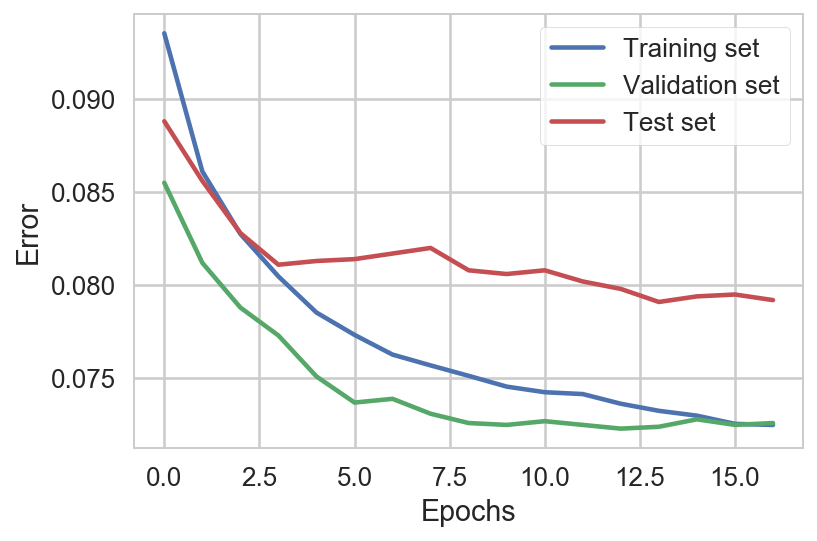

In [29]:
plt.plot(train_errors, label='Training set')
plt.plot(validation_errors, label='Validation set')
plt.plot(test_errors, label='Test set')
plt.legend(loc='best', frameon=True)
plt.xlabel('Epochs')
plt.ylabel('Error')

## Programming Multilayer Perceptron

We need to start by defining a hidden layer.

Typical hidden layer of a MLP: units are fully-connected and have sigmoidal activation function. Weight matrix W is of shape (n_in,n_out) and the bias vector b is of shape (n_out,).

**Note**: 
* The nonlinearity used here is $\tanh()$
* Hidden unit output is given by: `tanh(dot(input,W) + b)`.

The softmax function, or normalized exponential, is a generalization of the logistic function that "squashes" a $K$-dimensional vector $\vec{z}$ of arbitrary real values to a $K$-dimensional vector $\sigma(\vec{z})$ of real values in the range (0, 1) that add up to 1. The function is given by

$$
\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}\quad    \text{for}\ j = 1,\ldots, K.
$$

In [30]:
class HiddenLayer():
    def __init__(self,
                 rng,
                 input,
                 n_in,
                 n_out,
                 W=None,
                 b=None,
                 activation=T.tanh):
        """
        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)),
                dtype=theano.config.floatX)
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out, ), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (lin_output
                       if activation is None else activation(lin_output))
        # parameters of the model
        self.params = [self.W, self.b]

## Multi-Layer Perceptron Class

A multilayer perceptron is a feedforward artificial neural network model that has one layer or more of hidden units and nonlinear activations. Intermediate layers usually have as activation function tanh or the sigmoid function (defined here by a ``HiddenLayer`` class)  while the top layer is a softmax layer (defined here by a ``LogisticRegression`` class).

The softmax function, or normalized exponential, is a generalization of the logistic function that "squashes" a $K$-dimensional vector $\vec{z}$ of arbitrary real values to a $K$-dimensional vector $\sigma(\vec{z})$ of real values in the range (0, 1) that add up to 1. The function is given by

$$
\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}\quad    \text{for}\ j = 1,\ldots, K.
$$

In [31]:
class MLP:
    def __init__(self, rng, input, n_in, n_hidden, n_out, activation=T.tanh):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie
        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hidden_layer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=activation)

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.log_regression_layer = LogisticRegression(
            input=self.hidden_layer.output, n_in=n_hidden, n_out=n_out)

        # L1 norm ; one regularization option is to enforce L1 norm to be small
        self.L1 = abs(self.hidden_layer.W).sum() + abs(
            self.log_regression_layer.W).sum()

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (self.hidden_layer.W**2).sum() + (
            self.log_regression_layer.W**2).sum()

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = self.log_regression_layer.negative_log_likelihood

        # same holds for the function computing the number of errors
        self.errors = self.log_regression_layer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hidden_layer.params + self.log_regression_layer.params

        # keep track of model input
        self.input = input

In [32]:
dataset='mnist.pkl.gz'
batch_size=30

In [33]:
datasets = load_data(dataset)

In [34]:
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

Compute number of minibatches for training, validation and testing

In [35]:
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

In [36]:
patience = 5000  # look as this many examples regardless
validation_frequency = min(n_train_batches, patience // 2)
# go through this many
# minibatches before checking the network
# on the validation set; in this case we
# check every epoch

Allocate symbolic variables for the data

In [37]:
index = T.lscalar()  # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of [int] labels

In [38]:
rng = numpy.random.RandomState(42)

Creating the MLP class instance

In [39]:
learning_rate=0.05
L1_reg=0.0001
L2_reg=0.0001 
n_epochs=300
n_hidden=500

In [40]:
mlp = MLP(rng=rng, input=x, n_in=28 * 28, n_hidden=n_hidden, n_out=10)

The cost we minimize during training is the negative log likelihood of the model plus the regularization terms (L1 and L2); cost is expressed here symbolically.

In [41]:
cost = mlp.negative_log_likelihood(y) + L1_reg * mlp.L1 + L2_reg * mlp.L2_sqr

Compiling a Theano function that computes the mistakes that are made by the model on a minibatch

In [42]:
test_model = theano.function(
    inputs=[index],
    outputs=mlp.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [43]:
validate_model = theano.function(
    inputs=[index],
    outputs=mlp.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [44]:
train_set_loss = theano.function(
    inputs=[index],
    outputs=mlp.errors(y),
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

Compute the gradient of cost with respect to the parameters (sorted in `classifier.params`) the resulting gradients will be stored in a list `gparams`.

In [45]:
gparams = [T.grad(cost, param) for param in mlp.params]

Specify how to update the parameters of the model as a list of `(variable, update expression)` pairs.

In [46]:
updates = [(param, param - learning_rate * gparam) 
           for param, gparam in zip(mlp.params, gparams)]

Compiling a Theano function `train_model` that returns the cost, and at the same time, updates the parameter of the model based on the rules
defined in `updates`.

In [47]:
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [48]:
%%time
train_errors, validation_errors, test_errors = train(
    mlp,
    train_model,
    validate_model,
    test_model,
    n_epochs,
    n_train_batches,
    n_valid_batches,
    n_test_batches,
    validation_frequency,
    verbose=True,
    log_results=True)

epoch 1, minibatch 1666/1666, validation error 8.518519%
epoch 2, minibatch 1666/1666, validation error 7.907908%
epoch 3, minibatch 1666/1666, validation error 7.487487%
epoch 4, minibatch 1666/1666, validation error 6.996997%
epoch 5, minibatch 1666/1666, validation error 6.466466%
epoch 6, minibatch 1666/1666, validation error 5.875876%
epoch 7, minibatch 1666/1666, validation error 5.335335%
epoch 8, minibatch 1666/1666, validation error 4.984985%
epoch 9, minibatch 1666/1666, validation error 4.634635%
epoch 10, minibatch 1666/1666, validation error 4.284284%
epoch 11, minibatch 1666/1666, validation error 4.104104%
epoch 12, minibatch 1666/1666, validation error 3.883884%
epoch 13, minibatch 1666/1666, validation error 3.603604%
epoch 14, minibatch 1666/1666, validation error 3.493493%
epoch 15, minibatch 1666/1666, validation error 3.383383%
epoch 16, minibatch 1666/1666, validation error 3.283283%
epoch 17, minibatch 1666/1666, validation error 3.163163%
epoch 18, minibatch 166

epoch 142, minibatch 1666/1666, validation error 2.272272%
epoch 143, minibatch 1666/1666, validation error 2.272272%
epoch 144, minibatch 1666/1666, validation error 2.272272%
epoch 145, minibatch 1666/1666, validation error 2.292292%
epoch 146, minibatch 1666/1666, validation error 2.302302%
epoch 147, minibatch 1666/1666, validation error 2.302302%
epoch 148, minibatch 1666/1666, validation error 2.312312%
epoch 149, minibatch 1666/1666, validation error 2.292292%
epoch 150, minibatch 1666/1666, validation error 2.292292%
epoch 151, minibatch 1666/1666, validation error 2.282282%
epoch 152, minibatch 1666/1666, validation error 2.282282%
epoch 153, minibatch 1666/1666, validation error 2.282282%
epoch 154, minibatch 1666/1666, validation error 2.292292%
epoch 155, minibatch 1666/1666, validation error 2.292292%
epoch 156, minibatch 1666/1666, validation error 2.302302%
epoch 157, minibatch 1666/1666, validation error 2.302302%
epoch 158, minibatch 1666/1666, validation error 2.30230

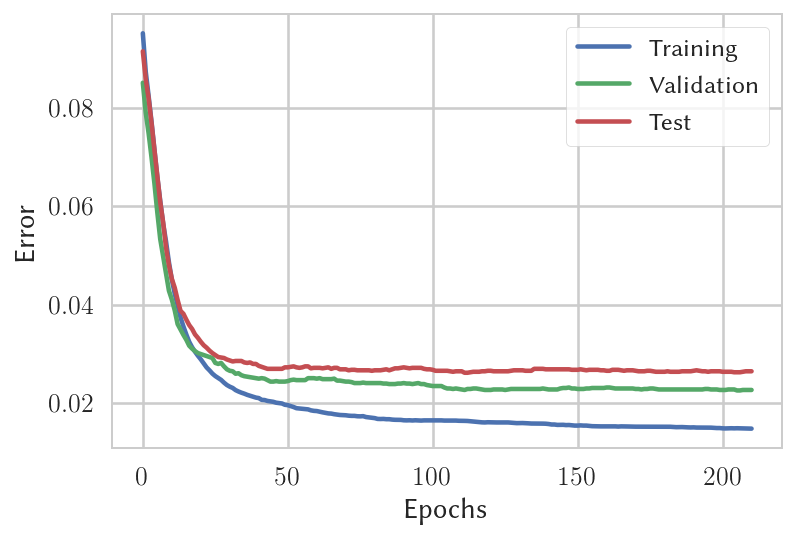

In [49]:
plt.plot(train_errors, label='Training')
plt.plot(validation_errors, label='Validation')
plt.plot(test_errors, label='Test')
plt.legend(loc='best', frameon=True)
plt.xlabel('Epochs')
plt.ylabel('Error')

## Improvement 1: Rectified Linear Unit activation

In [50]:
def relu(x):
    return x * (x > 0)

In [51]:
rng = numpy.random.RandomState(1234)

mlp_relu = MLP(rng=rng,
               input=x,
               n_in=28 * 28,
               n_hidden=n_hidden,
               n_out=10,
               activation=relu)

In [52]:
cost = mlp_relu.negative_log_likelihood(
    y) + L1_reg * mlp_relu.L1 + L2_reg * mlp_relu.L2_sqr

Compiling a Theano function that computes the mistakes that are made by the model on a minibatch

In [53]:
test_model = theano.function(
    inputs=[index],
    outputs=mlp_relu.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [54]:
validate_model = theano.function(
    inputs=[index],
    outputs=mlp_relu.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [55]:
train_set_loss = theano.function(
    inputs=[index],
    outputs=mlp_relu.errors(y),
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

Compute the gradient of cost with respect to the parameters (sorted in `classifier.params`) the resulting gradients will be stored in a list `gparams`.

In [56]:
gparams = [T.grad(cost, param) for param in mlp_relu.params]

Specify how to update the parameters of the model as a list of `(variable, update expression)` pairs.

* given two lists of the same length, `A = [a1, a2, a3, a4]` and `B = [b1, b2, b3, b4]`, `zip()` generates a list `C` of same size, where eachnelement is a pair formed from the two lists:
```python
C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
```

In [57]:
updates = [(param, param - learning_rate * gparam) 
           for param, gparam in zip(mlp_relu.params, gparams)]

Compiling a Theano function `train_model` that returns the cost, and at the same time, updates the parameter of the model based on the rules
defined in `updates`.

In [58]:
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size:(index + 1) * batch_size],
        y: train_set_y[index * batch_size:(index + 1) * batch_size]
    })

In [59]:
%%time
errors_relu = train(
    mlp_relu,
    train_model,
    validate_model,
    test_model,
    n_epochs,
    n_train_batches,
    n_valid_batches,
    n_test_batches,
    validation_frequency,
    verbose=True,
    log_results=True)

epoch 1, minibatch 1666/1666, validation error 7.607608%
epoch 2, minibatch 1666/1666, validation error 5.735736%
epoch 3, minibatch 1666/1666, validation error 4.604605%
epoch 4, minibatch 1666/1666, validation error 4.134134%
epoch 5, minibatch 1666/1666, validation error 3.763764%
epoch 6, minibatch 1666/1666, validation error 3.563564%
epoch 7, minibatch 1666/1666, validation error 3.403403%
epoch 8, minibatch 1666/1666, validation error 3.243243%
epoch 9, minibatch 1666/1666, validation error 3.133133%
epoch 10, minibatch 1666/1666, validation error 3.023023%
epoch 11, minibatch 1666/1666, validation error 2.882883%
epoch 12, minibatch 1666/1666, validation error 2.792793%
epoch 13, minibatch 1666/1666, validation error 2.702703%
epoch 14, minibatch 1666/1666, validation error 2.702703%
epoch 15, minibatch 1666/1666, validation error 2.682683%
epoch 16, minibatch 1666/1666, validation error 2.602603%
epoch 17, minibatch 1666/1666, validation error 2.552553%
epoch 18, minibatch 166

In [60]:
train_errors_relu, validation_errors_relu, test_errors_relu = errors_relu

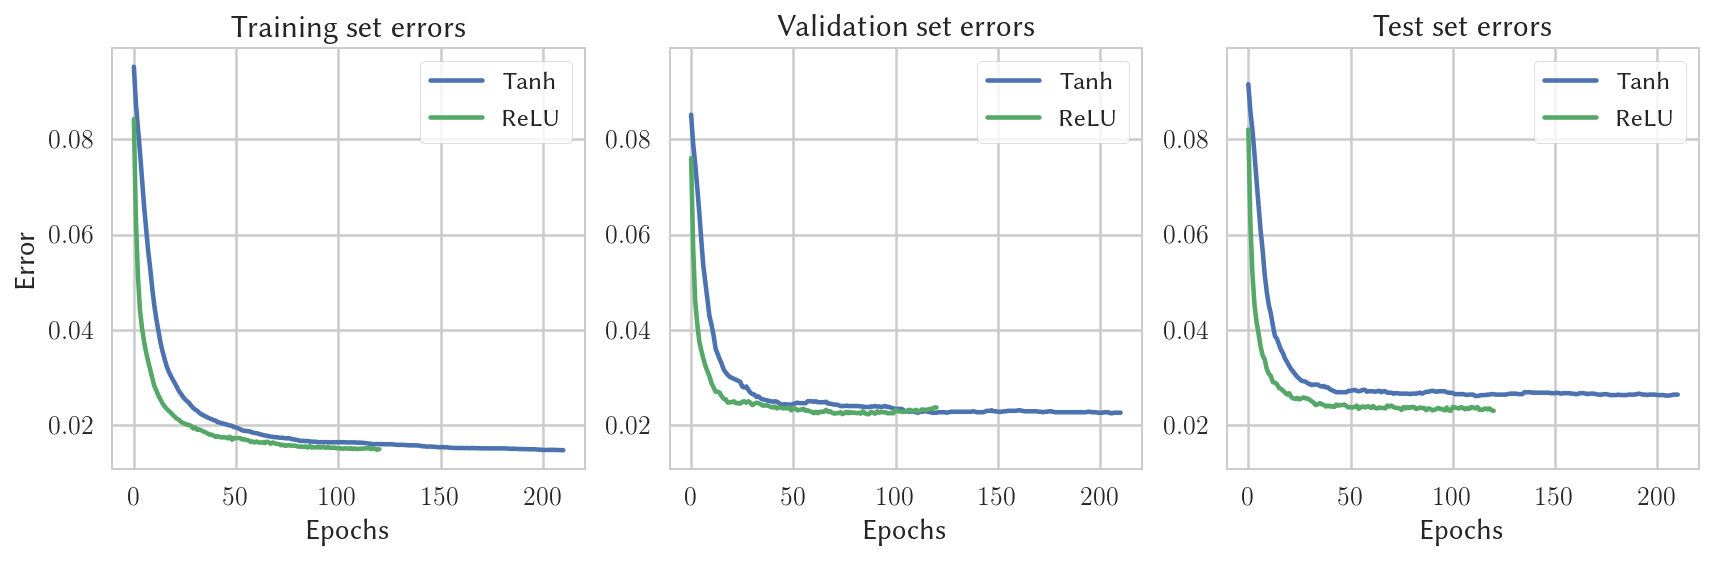

In [61]:
plt.figure(figsize=(12, 4))
ax = plt.subplot(131)
plt.plot(train_errors, label='Tanh')
plt.plot(train_errors_relu, label='ReLU')
plt.legend(loc='best', frameon=True)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training set errors')
plt.subplot(132, sharey=ax)
plt.plot(validation_errors, label='Tanh')
plt.plot(validation_errors_relu, label='ReLU')
plt.legend(loc='best', frameon=True)
plt.xlabel('Epochs')
plt.title('Validation set errors')
plt.subplot(133, sharey=ax)
plt.plot(test_errors, label='Tanh')
plt.plot(test_errors_relu, label='ReLU')
plt.legend(loc='best', frameon=True)
plt.xlabel('Epochs')
plt.title('Test set errors')
plt.tight_layout()

## Homework

* Implement a MLP that can have different numbers of hidden layers.
* Add the momentum term to gradients.

In [13]:
%load_ext version_information
%version_information scipy, numpy, matplotlib, sklearn, theano

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
IPython 6.1.0
OS Darwin 16.6.0 x86_64 i386 64bit
scipy 0.19.0
numpy 1.12.1
matplotlib 2.0.2
sklearn 0.18.1
theano 0.9.0
Sun Jun 11 23:47:32 2017 CEST

In [14]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

 ---